# <div align="center">YOLO Parking Spot  🚗🅿️</div>
<hr>

### In this notebook, you can assess the performance of the models in prediction and determine if they have achieved satisfactory results:

- [Processing the parking lot images](#section-1)
    - [Without YOLO](#without-yolo)
    - [YOLOv5](#yolov5-model)
        - [Trained YOLOv5n](#my-yolov5n)
        - [Trained YOLOv5s](#my-yolov5s)
    - [YOLOv8](#yolov8-model)
        - [Trained YOLOv8n](#my-yolov8n)
        - [Trained YOLOv8s](#my-yolov8s)
    - [Custom model](#custom-model)
- [Comparing the Models](#comparing-the-models)
    - [my_yolov5n.pt](#)
    - [my_yolov5s.pt](#)
    - [my_yolov8n.pt](#)
    - [my_yolov8s.pt](#)


In [1]:
import pandas as pd
import sys
import os

# Add the path to the utils folder to the system path
if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.append('../')

from utils.functions import process_images
from utils.functions import plot_model_size, plot_model_params, plot_model_gflops, plot_precision_recall, plot_mAP, save_plots

# Get current working directory
repo_path = os.path.dirname(os.getcwd())

## <div id="section-1">Processing the parking lot images</div>
<hr>

### <div id="without-yolo">Without YOLO</div>
The following cell generates the images that we will be using to compare the custom models later on.

In [2]:
# Specify the folder path containing the images and annotations
data_path = os.path.join(repo_path, 'data')

# Specify the output folder path
output_folder = os.path.join(repo_path, 'results/without_yolo/')

# process_images returns a dataframe containing the results
without_yolo_results = process_images(data_path, output_folder, highlighted_cars=True)
without_yolo_results.head() # Show the results for the first 5 images

Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


### <div id="yolov5-model">YOLOv5</div>
The following cell will generate the processed images with the labels provided by the YOLOv5 model's prediction.

#### <div id="my-yolov5n">Predictions provided by my trained YOLOv5n model

In [3]:
# Specify the model name
model = 'my_yolov5n'

# Specify the folder path containing the images and annotations
data_path = os.path.join(repo_path, 'data')

# Specify the output folder path
output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
yolov5n_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov5n_results.head() # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov5n/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


#### <div id="my-yolov5s">Predictions provided by my trained YOLOv5s model</div>

In [4]:
model = 'my_yolov5s'
output_folder = f'{repo_path}/results/{model}/'
yolov5s_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov5s_results.head() # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov5s/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


### <div id="yolov8-model">YOLOv8</div>

The following cell will generate the processed images with the labels provided by the YOLOv8 model's predictions.

#### <div id="my-yolov8n">Predictions provided by my trained YOLOv8n model

In [5]:
# Specify the model name
model = 'my_yolov8n'

# Specify the folder path containing the images and annotations
data_path = os.path.join(repo_path, 'data')

# Specify the output folder path
output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
yolov8n_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov8n_results.head() # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov8n/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


#### <div id="my-yolov8s">Predictions provided by my trained YOLOv8s model

In [6]:
model = 'my_yolov8s'
output_folder = f'{repo_path}/results/{model}/'
yolov8s_results = process_images(data_path, output_folder, highlighted_cars=True, model=model)
yolov8s_results.head() # Show the results for the first 5 images

Using labels from c:\Users\mathe\Documents\Projects\YOLO-Parking-Spot\results/my_yolov8s/labels/
Processing images...
Processed 23 images ✅


,Image File,Disabled parking spots,Parking spots,Cars,Empty disabled parking spots,Occupied disabled parking spots,Empty parking spots,Occupied parking spots,Cars in transit or parked in non-parking spots
0,empty_set1_60m_1.jpg,20,70,1,20,0,69,1,0
1,empty_set1_60m_2.jpg,20,70,1,20,0,69,1,0
2,empty_set1_65m_1.jpg,22,77,0,22,0,77,0,0
3,empty_set1_70m_2.jpg,22,77,1,22,0,76,1,0
4,empty_set1_75m_1.jpg,22,77,0,22,0,77,0,0


### <div id="custom-model">Custom model</div>

#### If you want to train a model from scratch or make predictions with your trained model, go to the [yolov5](yolov5.ipynb) or [yolov8](yolov8.ipynb) notebooks ✨🚀

To use your **trained model** predictions, specify the model path and the labels directory in `output_folder`!<br>
Example:
```python
# Specify the model path or the model name if it is in the models folder.
model_path = f'{repo_path}models/yolov5n/runs/exp/weights/best.pt'
# model = "my_yolovXX.pt"

# Specify the output folder path
output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
results = process_images(data_path, output_folder, highlighted_cars=True, model=model_path)
results.head(20) # # Show the results for the first 20 images
```

In [7]:
# Specify the model path or the model name if it is in the models folder.
#model_path = f'{repo_path}models/yolov5n/runs/exp/weights/best.pt'
#model = "my_yolovXX.pt"

# Specify the output folder path
#output_folder = f'{repo_path}/results/{model}/'

# process_images returns a dataframe containing the results
#results = process_images(data_path, output_folder, highlighted_cars=True, model=model_path)
#results.head(20) # # Show the results for the first 20 images

## Comparing the Models
<hr>

First of all, let's get the model summaries from the "models" folder.

In [8]:
# Path to the CSV file
filename = f'{repo_path}/models/models_summary.csv'

# Import the CSV file into a pandas DataFrame
models_summary = pd.read_csv(filename, thousands='.', decimal=',')

# Show the models summary
models_summary.head()

,Model,Model Size (MB),Layers,Parameters,GFLOPs,Instances,Precision,Recall,mAP0-50,mAP50-95
0,YOLOv5n,4.8,157,1760518,4.1,296,0.999,0.993,0.995,0.774
1,YOLOv5s,15.3,157,7012822,15.8,292,1.000,0.995,0.995,0.800
2,YOLOv8n,6.2,168,3005843,8.1,308,0.978,0.987,0.995,0.810
3,YOLOv8s,22.7,168,11125971,28.4,195,0.999,1.000,0.995,0.805


### Model Size Comparison

This bar plot shows the model size in MB for each model. It provides a visual comparison of the size differences among the models.

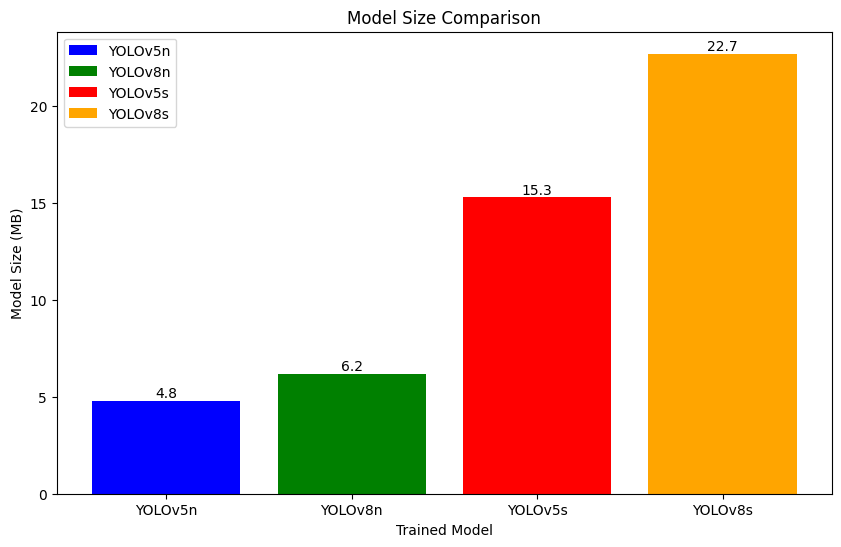

In [9]:
# %% [hide]
plot_model_size(models_summary)

### Model Parameters Comparison

This bar plot shows the number of model parameters for each model. It provides a visual comparison of the differences in parameters among the models.

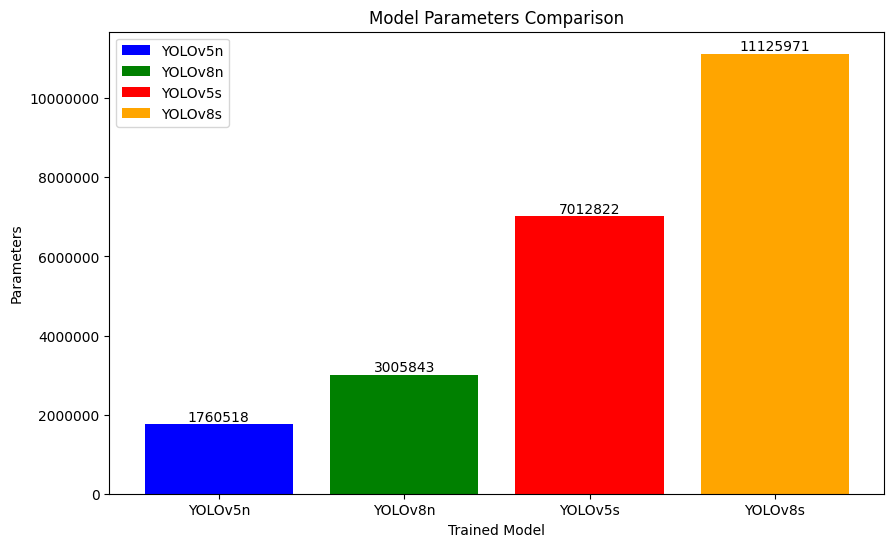

In [10]:
# %% [hide]
plot_model_params(models_summary)

The YOLOv5 models have 157 layers, while the YOLOv8 models have 168 layers.

### Model GFLOPs Comparison

This bar plot shows the GFLOPs (giga floating-point operations) for each model, providing a visual comparison of the differences in GFLOPs among the models.

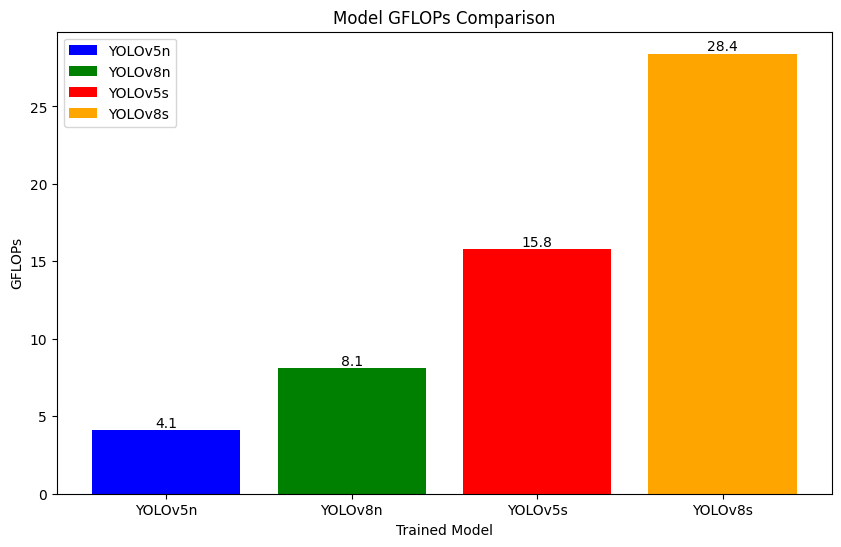

In [11]:
# %% [hide]
plot_model_gflops(models_summary)

## Precision and Recall Comparison

This line plot compares the precision and recall scores for each model. It helps in understanding the trade-off between precision and recall among different models.

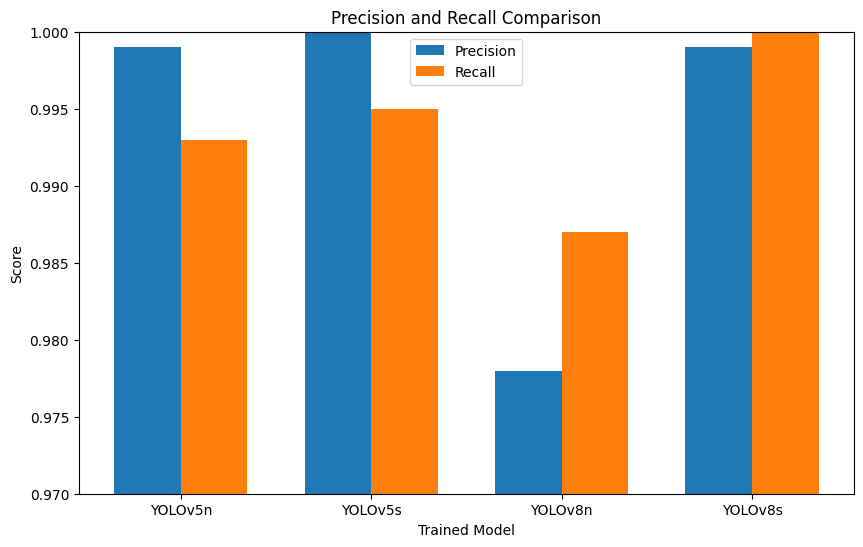

In [12]:
# %% [hide]
plot_precision_recall(models_summary)

## mAP 50-95 Comparison

This bar plot compares the mAP50-95 scores for each model. It provides insights into the overall performance of the models in terms of mean Average Precision (mAP50-95).

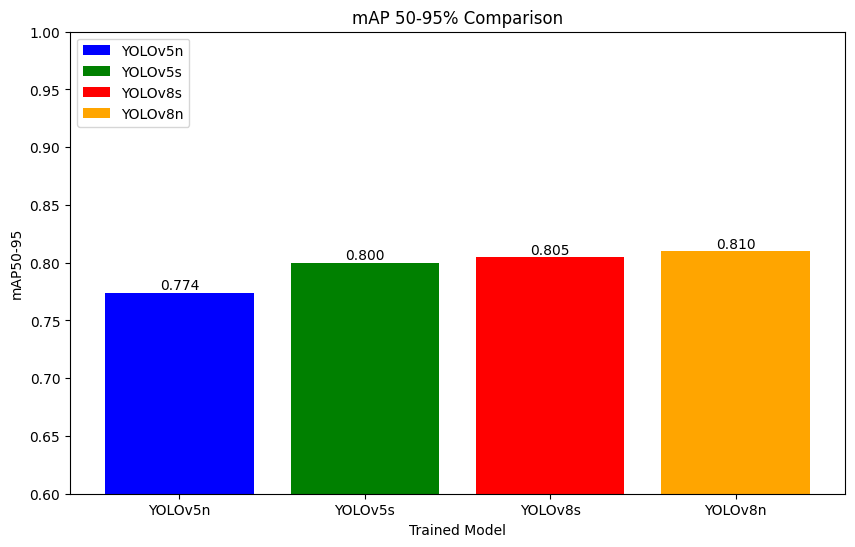

In [13]:
# %% [hide]
plot_mAP(models_summary)

In [14]:
# %% [hide]
save_plots()

## Comparing the Results
<hr>